# Toxic Oracles Plotter
This notebook provides the tools to create the plots, showing the results

In [37]:
# imports
import os
import sys
from generalComparison import load_data, plotCategories, grouped
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [38]:
# using the function load_data, the data is loaded in a pandas dataframe with the columns: iteration, score, system_generator, prompt_generator, delta_time_evaluation, delta_time_generation, delta_time_response, numberIterations
results="results/finalTests"
# each config is a folder with the results of the experiments
folders = [f.path for f in os.scandir(results) if f.is_dir()] #and f.name != "vicunaUC_vicunaUC"]

df=load_data(input=folders, criteria="max", includeBaseline=True)

## Renaming 
max -> vanilla

max_fx -> IE

max_fs_glit -> IE+GL

max_mem_5_fs_glit -> IE+SE+GL

baseline -> RS

In [39]:
# renaming the values in file column 
#df["file"]=df["file"].replace({"max":"vanilla", "max_fs": "IE", "max_fs_glit": "IE+GL", "max_mem_5_fs_glit":"IE+SE+GL", "baseline": "RS"})

In [40]:
# order the values following the order:
# RS, vanilla, IE, IE+GL, IE+SE+GL
#df["file"]=pd.Categorical(df["file"], categories=["RS", "vanilla", "IE", "IE+GL", "IE+SE+GL"], ordered=True)

In [41]:
# pick only the last iteration (shown with numberIteration)
dfFinal = df[df['iteration'] == df['numberIterations']]
# drop the iteration column
dfFinal = dfFinal.drop(columns=['numberIterations'])

In [42]:
# list of systems under test
suts=dfFinal["system_under_test"].unique()

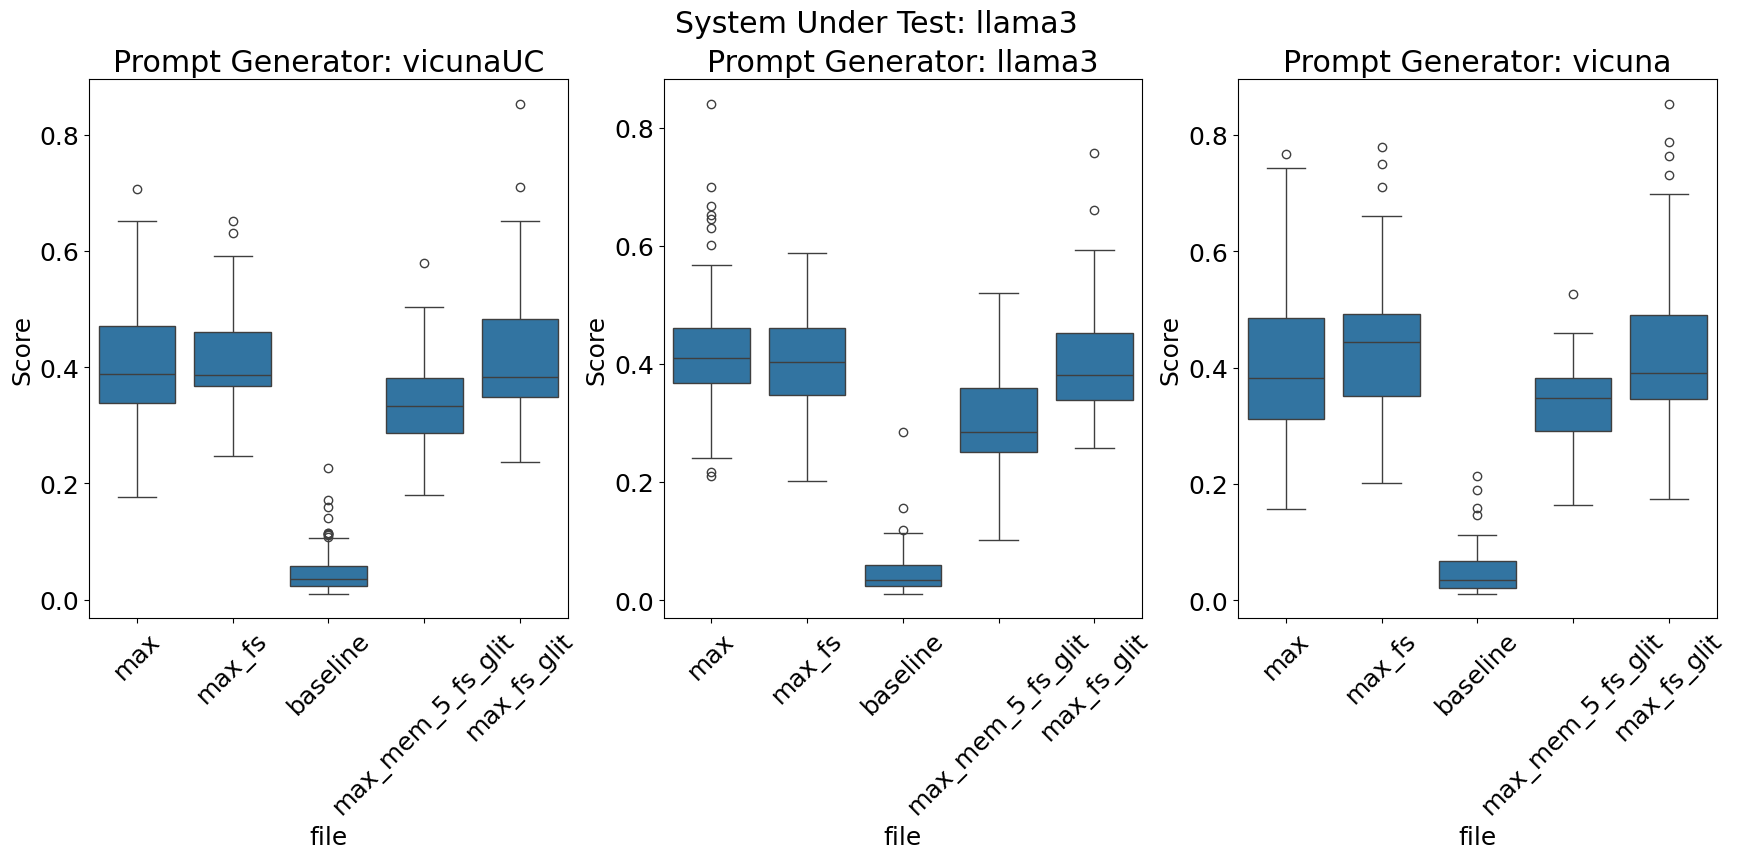

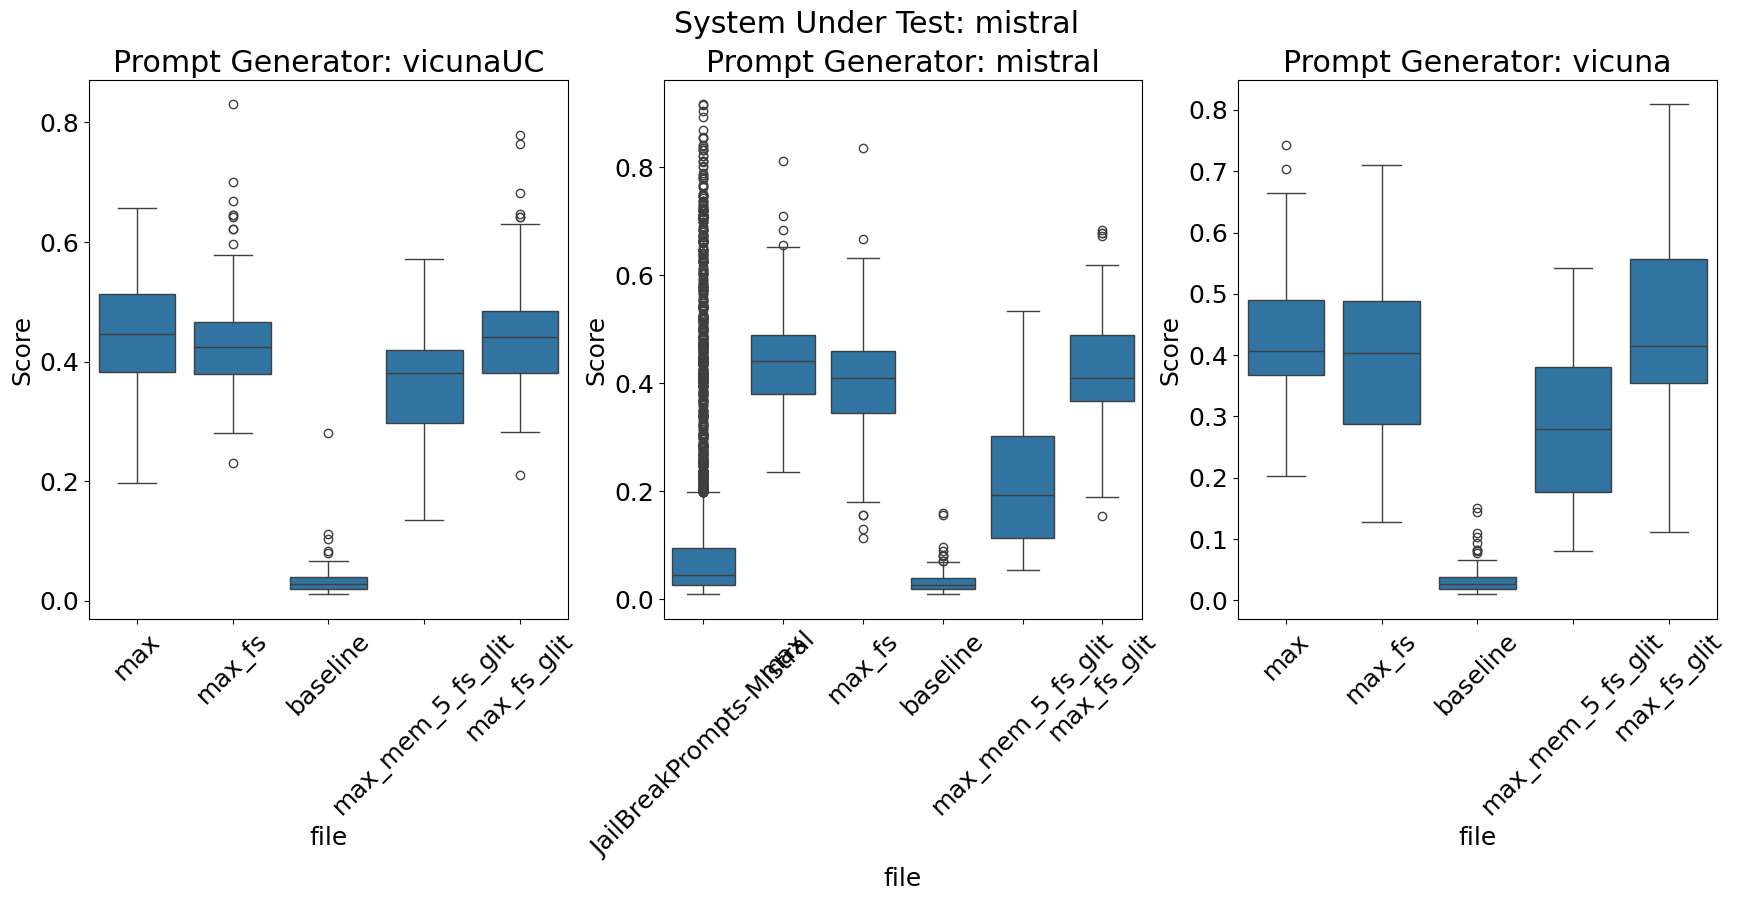

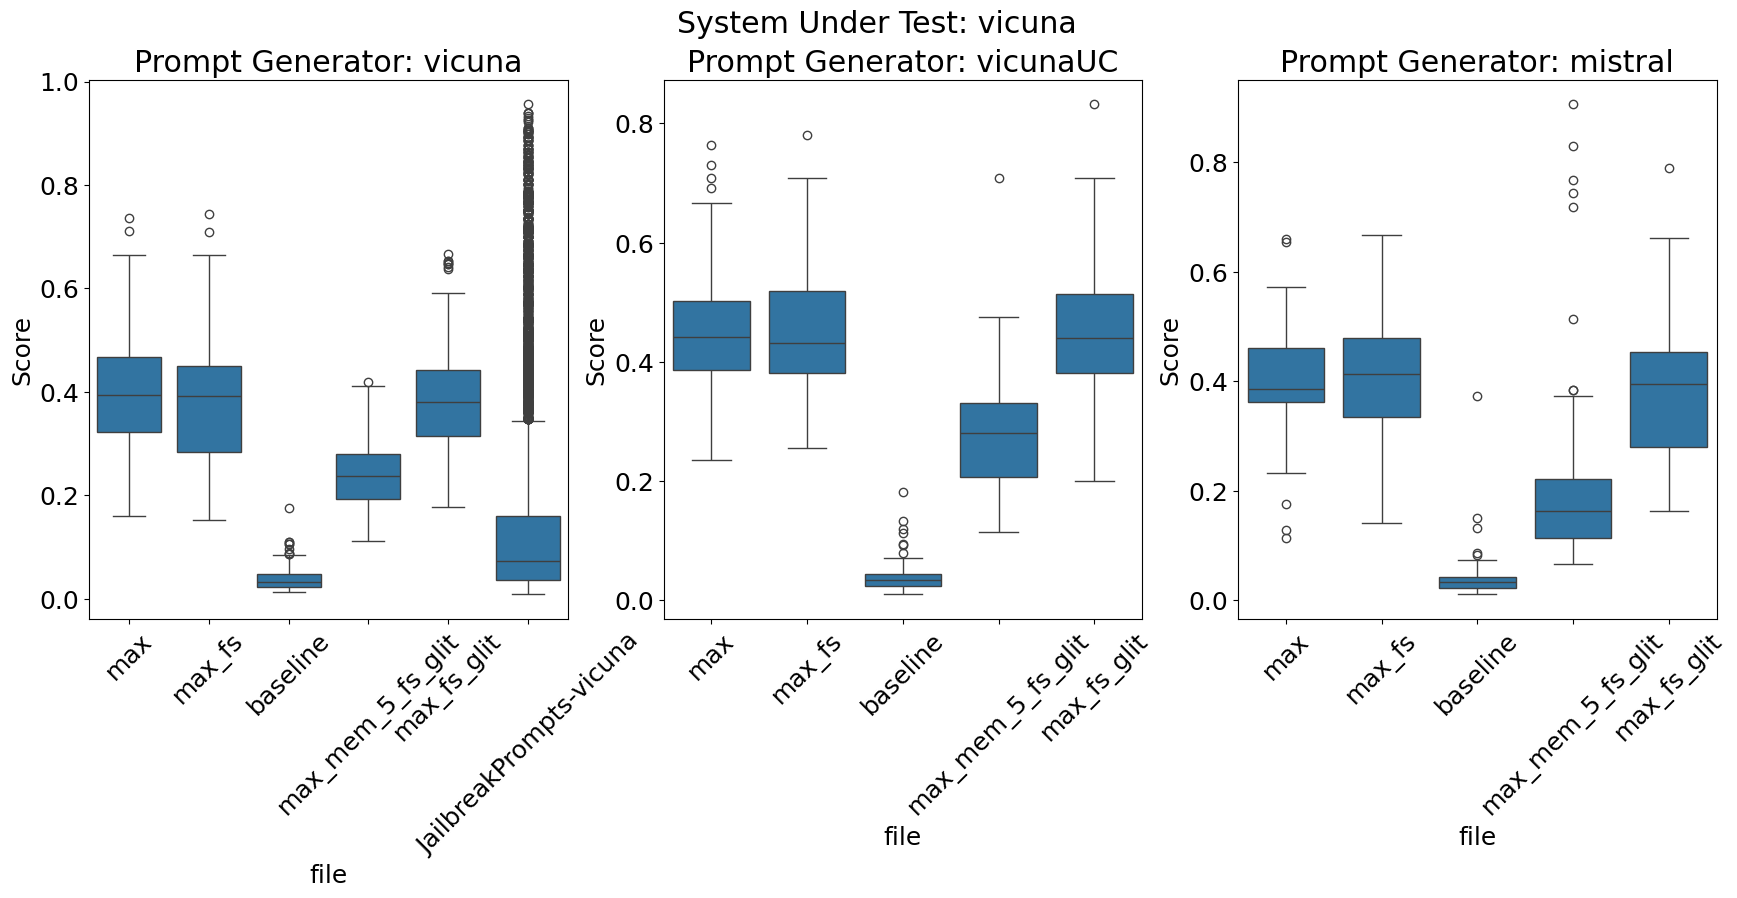

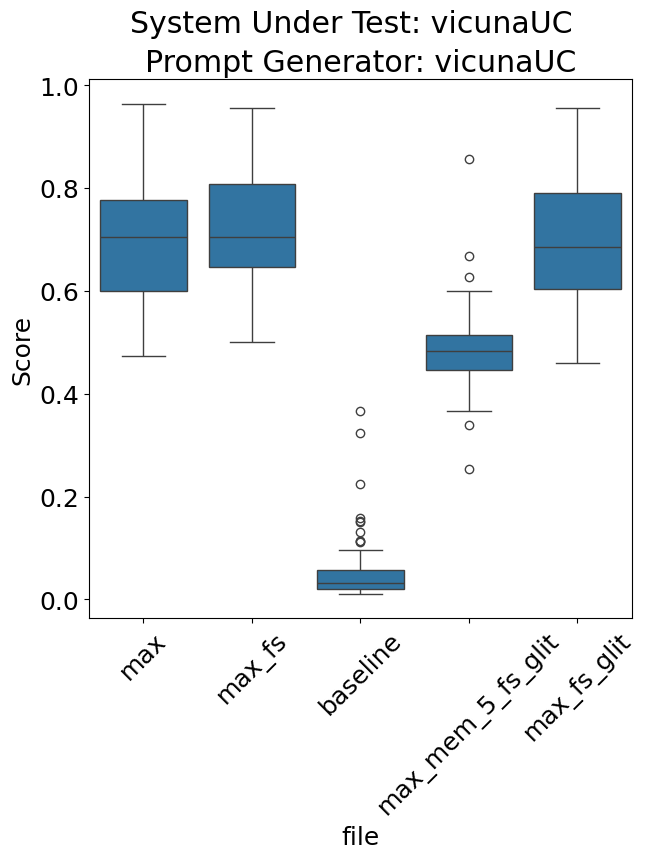

In [43]:
for sut in suts:
    # plots a boxplot of the scores for each prompt generator, by file name
    prompt_generators=dfFinal[dfFinal["system_under_test"]==sut]["prompt_generator"].unique()
    # one subplot for each prompt generator
    width=7*len(prompt_generators)
    fig, ax= plt.subplots(1, len(prompt_generators), figsize=(width, 7))
    for i, prompt_generator in enumerate(prompt_generators):
        
        data=dfFinal[(dfFinal["system_under_test"]==sut) & (dfFinal["prompt_generator"]==prompt_generator)]

        if len(prompt_generators)==1:
            # only one prompt generator
            sns.boxplot(x="file", y="score", data=data, ax=ax)
            ax.set_title("Prompt Generator: "+prompt_generator)
            ax.set_ylabel("Score")
            # rotate the x labels
            ax.tick_params(axis='x', rotation=45)
        else:
            sns.boxplot(x="file", y="score", data=data, ax=ax[i])
            ax[i].set_title("Prompt Generator: "+prompt_generator)
            ax[i].set_ylabel("Score")
            # rotate the x labels
            ax[i].tick_params(axis='x', rotation=45)
        
    plt.suptitle("System Under Test: "+sut)

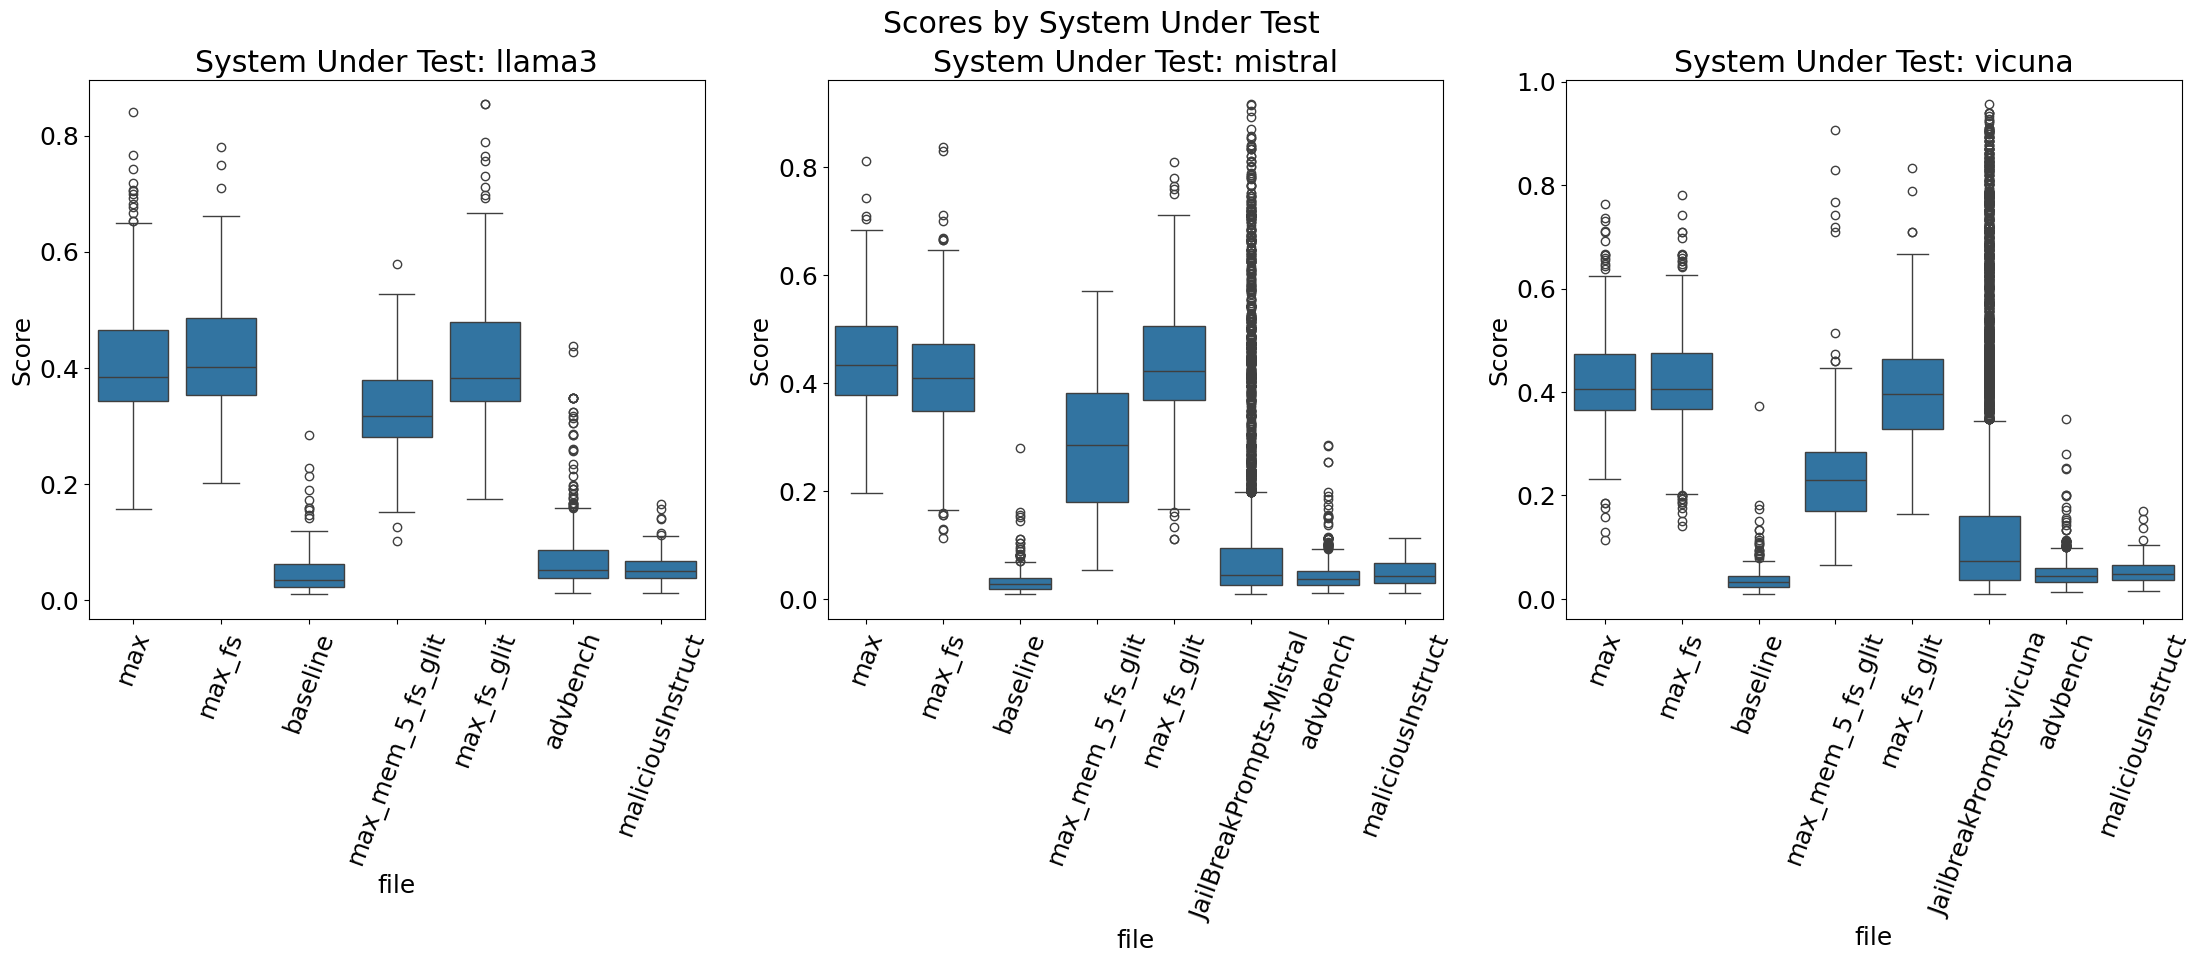

In [44]:
# duplicate the dataframe
dfFinal2=dfFinal.copy()
# drop the generator columns
dfFinal2=dfFinal2.drop(columns=["prompt_generator"])
# drop vicunaUC
dfFinal2=dfFinal2[dfFinal2["system_under_test"]!="vicunaUC"]


# add the files in rebuttal
folder1="results/rebuttal"
folders1 = [f.path for f in os.scandir(folder1) if f.is_dir()]
dfRebuttal=load_data(input=folders1, criteria="max", includeBaseline=True)
# drop the prompt generator column
dfRebuttal=dfRebuttal.drop(columns=["prompt_generator"])

# merge the dataframes
dfFinal3=pd.concat([dfFinal2, dfRebuttal])

# boxplot of the scores for each system under test, by file name
# one subplot for each system under test
width=7*len(suts)-1
fig, ax= plt.subplots(1, len(suts)-1, figsize=(width, 7))
suts2=suts[suts!="vicunaUC"]
for i, sut in enumerate(suts2):
    data=dfFinal3[dfFinal3["system_under_test"]==sut]
    sns.boxplot(x="file", y="score", data=data, ax=ax[i])
    ax[i].set_title("System Under Test: "+sut)
    ax[i].set_ylabel("Score")
    # rotate the x labels
    ax[i].tick_params(axis='x', rotation=70)

plt.suptitle("Scores by System Under Test")

plt.show()



# Time Costs

/var/folders/63/pknqbjy15d5bkgdpc7fb7x2w0000gn/T/ipykernel_19276/1993273775.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfTime["total_delta"]=df["delta_time_evaluation"]+df["delta_time_generation"]+df["delta_time_response"]


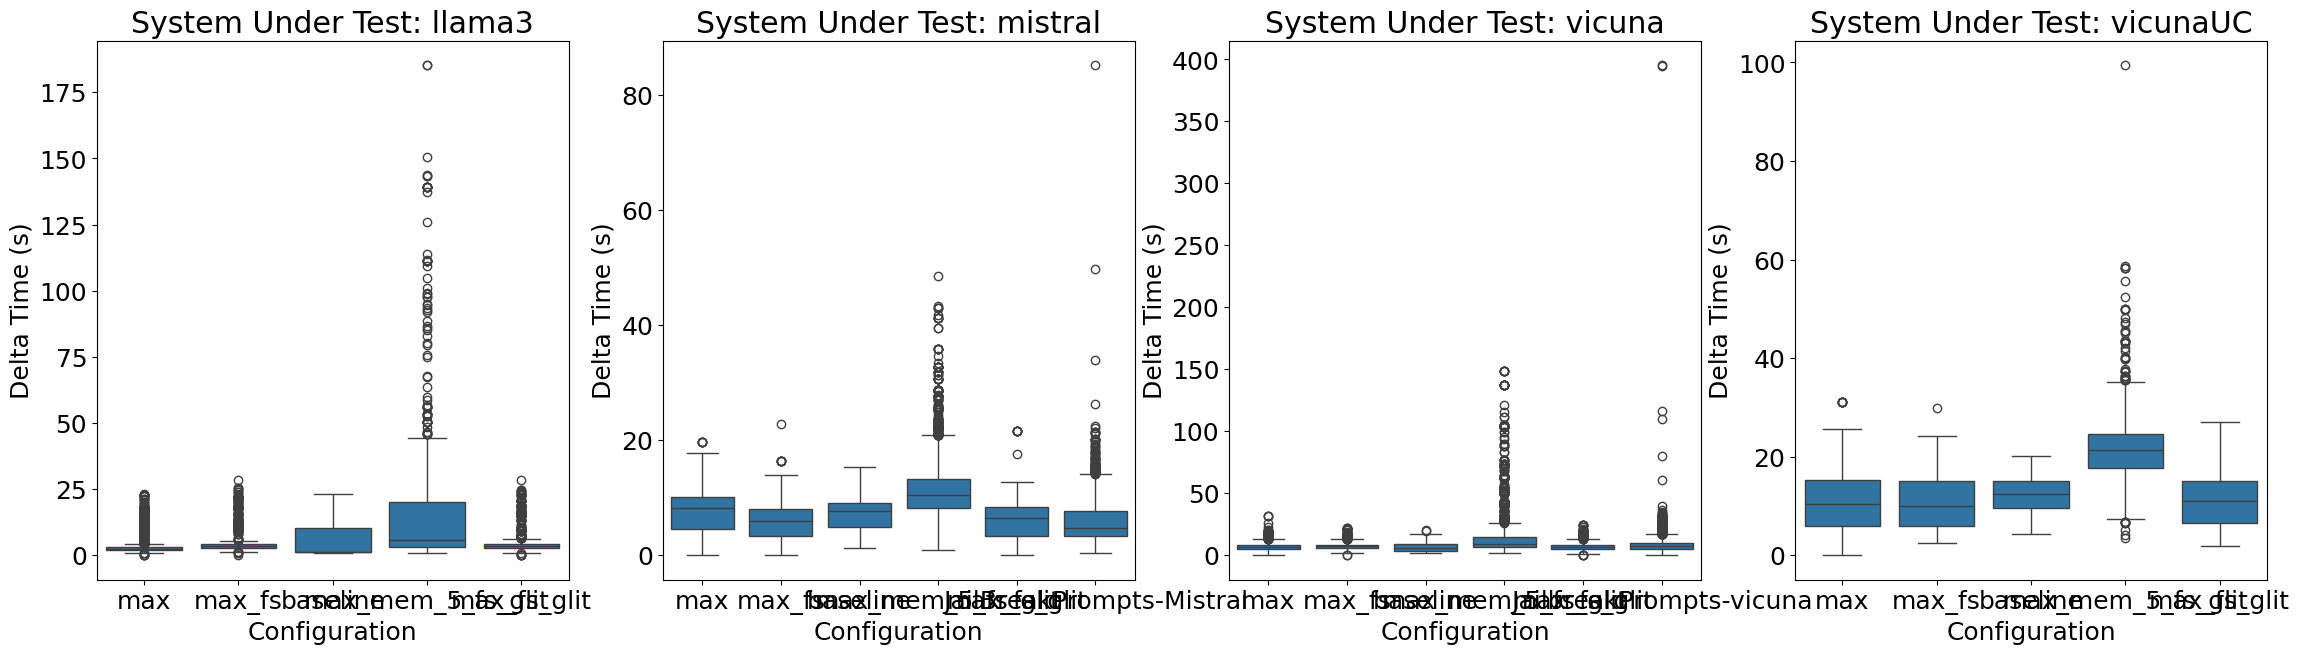

In [45]:
# create a row of plots, one for each system under test
fig, ax= plt.subplots(1, len(suts), figsize=(7*len(suts), 7))#, sharey=True)

# drop the rows that have -1 as value for any delta time (old version of the code, in which the delta times were not measured)
dfTime=df[(df["delta_time_evaluation"]!=-1) & (df["delta_time_generation"]!=-1) & (df["delta_time_response"]!=-1)]

# add new column to the dataframe, in which the delta are added
dfTime["total_delta"]=df["delta_time_evaluation"]+df["delta_time_generation"]+df["delta_time_response"]

# for each plot, the x axis is the iteration, the y axis is the delta time
for i, sut in enumerate(suts):
    # for each sut plot the delta time at each iteration
    plot_data=dfTime[dfTime["system_under_test"]==sut]

    # plot the delta time for each configuration
    sns.boxplot(x="file", y="total_delta", data=plot_data, ax=ax[i])
    ax[i].set_title("System Under Test: "+sut)
    ax[i].set_ylabel("Delta Time (s)")
    ax[i].set_xlabel("Configuration")

plt.show()

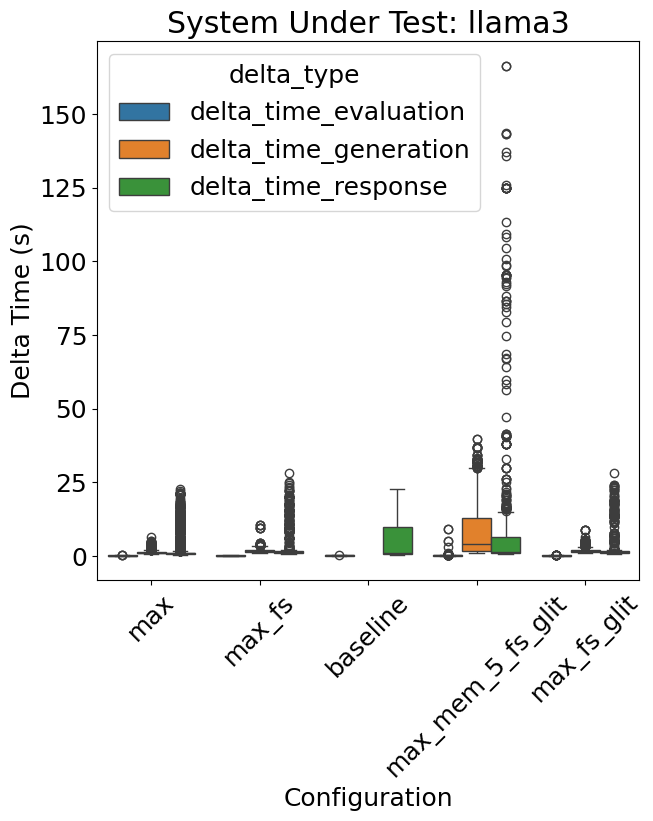

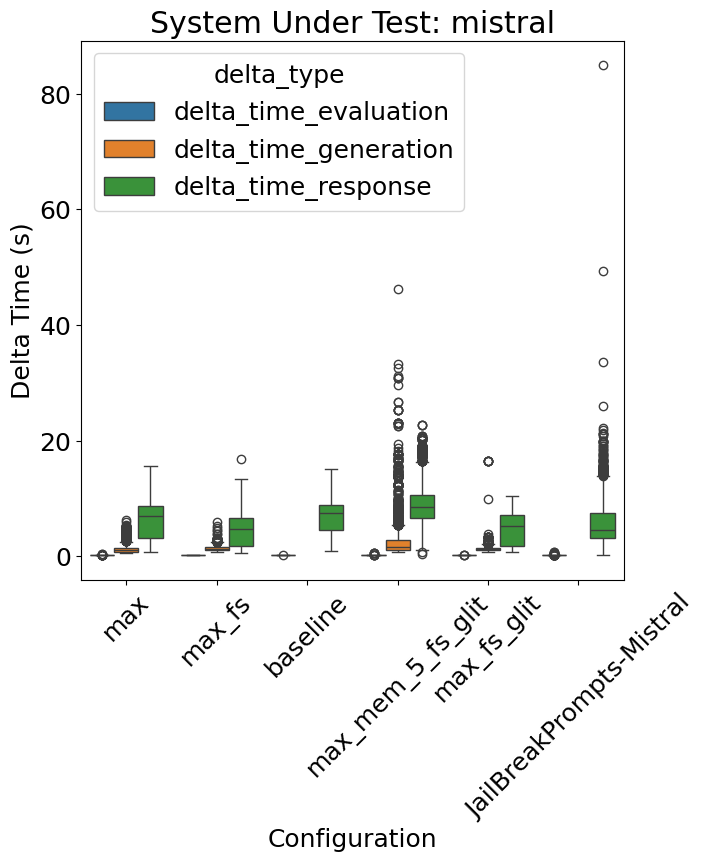

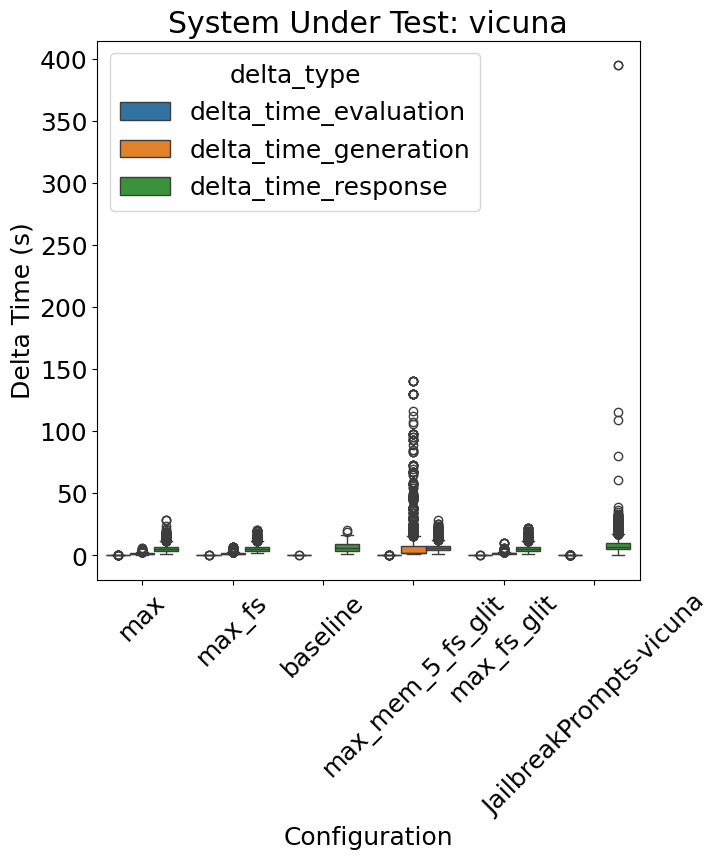

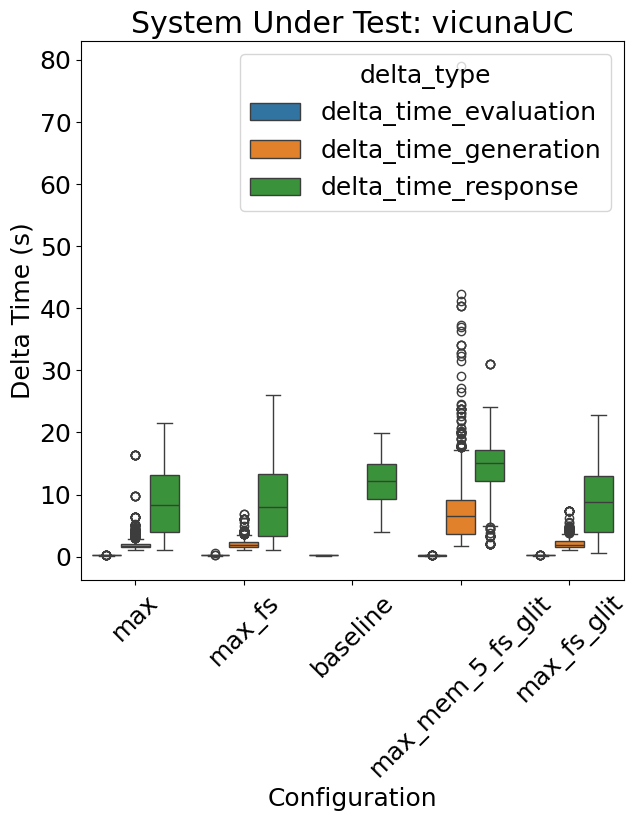

In [46]:
# create a row of plots, one for each system under test
#fig, ax= plt.subplots(len(suts),1, figsize=(7, 7*len(suts)))#, sharey=True)

# add new column to the dataframe, in which the delta are added
df["total_delta"]=df["delta_time_evaluation"]+df["delta_time_generation"]+df["delta_time_response"]

# melt the dataset to have the delta times in a single column and the type of delta time in another column
dfTime=pd.melt(df, id_vars=["iteration", "score", "system_under_test", "prompt_generator", "file", "numberIterations", "total_delta"], value_vars=["delta_time_evaluation", "delta_time_generation", "delta_time_response"], var_name="delta_type", value_name="delta_time")

# remove the delta_time=0
dfTime=dfTime[dfTime["delta_time"]>0]
# for each plot, the x axis is the iteration, the y axis is the delta time
for i, sut in enumerate(suts):
    fig, ax= plt.subplots(1, 1, figsize=(7, 7))#, sharey=True)
    # for each sut plot the delta time at each iteration
    data=dfTime[dfTime["system_under_test"]==sut]
    # drop the columns that have -1 as value for any delta time (old version of the code, in which the delta times were not measured)
    #data=data[(data["delta_time_evaluation"]!=-1) & (data["delta_time_generation"]!=-1) & (data["delta_time_response"]!=-1)]
    # drop the rows in which the delta time is -1
    data=data[data["delta_time"]!=-1]

    # plot the delta time for each configuration, using hue to differentiate the type of delta time
    sns.boxplot(x="file", y="delta_time", hue="delta_type", data=data, ax=ax)
    #sns.boxplot(x="file", y="delta_time", data=data, ax=ax[i])
    ax.set_title("System Under Test: "+sut)
    ax.set_ylabel("Delta Time (s)")
    ax.set_xlabel("Configuration")
    # tilt the x labels
    ax.tick_params(axis='x', rotation=45)
    # save the plots
    #plt.savefig("results/finalTests/boxplot_delta_time_"+sut+".svg", format="svg", dpi=300)

In [47]:
# after the past code, the baseline files need to be removed from the data
df=df[df["file"]!="RS"]

# Prompt Generator Comparison

Self - mi mi, lla lla

Vicuna - vi mi, vi lla

Vicunauc - uc mi, uc lla

In [48]:
# define a new dataframe, such that:
# - the columns are: prompt_generator, score
# - prompt generator 'self': all the runs with system equal prompt generator, excluding vicuna and vicunaUC
# - prompt generator 'Vicuna': all the runs with Vicuna as prompt generator (Mistral, LLama3)
# - prompt generator 'VicunaUC': all the runs with VicunaUC as prompt generator (Mistral, LLama3)
df=load_data(input=folders, criteria="max", includeBaseline=False)
# first, the data for the prompt generator 'self'
dfSelf=df[(df["prompt_generator"]==df["system_under_test"]) & (df["prompt_generator"]!="vicuna") & (df["prompt_generator"]!="vicunaUC")].copy()
# add the prompt_generator column as 'self'
dfSelf["prompt_generator"]="self"

# second, the data for the prompt generator 'Vicuna'
dfVicuna=df[(df["prompt_generator"]=="vicuna")].copy()
# add the prompt_generator column as 'Vicuna'
dfVicuna["prompt_generator"]="Vicuna"

# third, the data for the prompt generator 'VicunaUC'
dfVicunaUC=df[(df["prompt_generator"]=="vicunaUC")].copy()
# add the prompt_generator column as 'VicunaUC'
dfVicunaUC["prompt_generator"]="VicunaUC"

# concatenate the three dataframes
dfConcat=pd.concat([dfSelf, dfVicuna, dfVicunaUC])

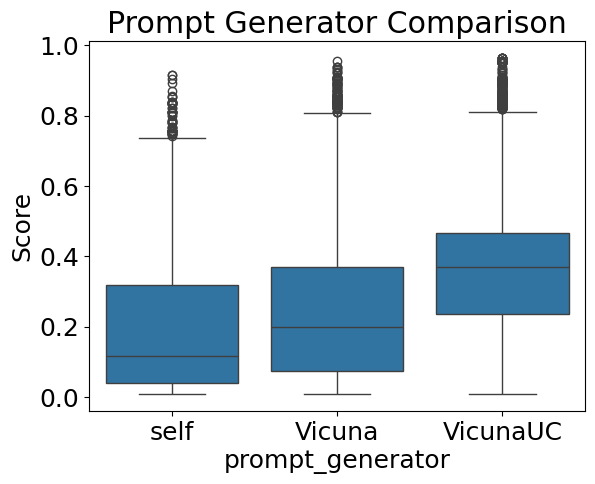

In [49]:
# plot the boxplot
sns.boxplot(x="prompt_generator", y="score", data=dfConcat)
plt.title("Prompt Generator Comparison")
plt.ylabel("Score")
plt.show()

## Last Iteration only
Instead here are the boxplot, only considering the last iteration

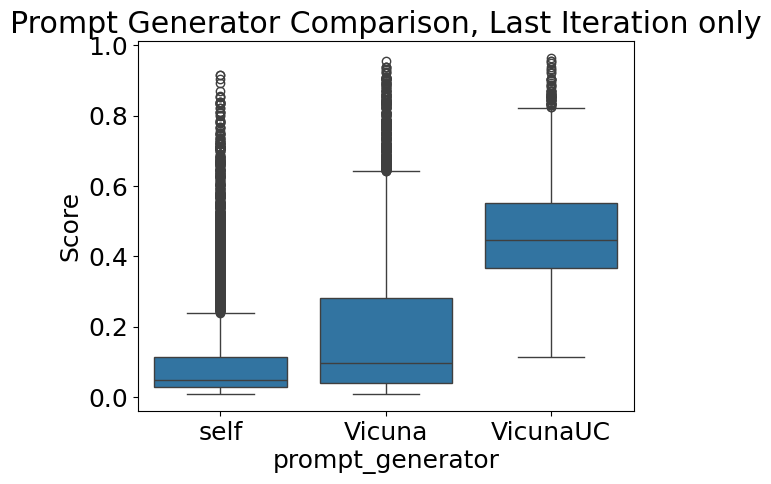

prompt_generator
Vicuna      0.185380
VicunaUC    0.468800
self        0.117889
Name: score, dtype: float64


In [50]:
dfLast=df[df["iteration"]==df["numberIterations"]]
dfSelf=dfLast[(dfLast["prompt_generator"]==dfLast["system_under_test"]) & (dfLast["prompt_generator"]!="vicuna") & (dfLast["prompt_generator"]!="vicunaUC")].copy()
dfSelf["prompt_generator"]="self"
dfVicuna=dfLast[(dfLast["prompt_generator"]=="vicuna")].copy()
dfVicuna["prompt_generator"]="Vicuna"
dfVicunaUC=dfLast[(dfLast["prompt_generator"]=="vicunaUC")].copy()
dfVicunaUC["prompt_generator"]="VicunaUC"
dfConcat=pd.concat([dfSelf, dfVicuna, dfVicunaUC])
# plot the average score
sns.boxplot(x="prompt_generator", y="score", data=dfConcat)
plt.title("Prompt Generator Comparison, Last Iteration only")
plt.ylabel("Score")
plt.show()


# comptue the average score for each prompt generator
print(dfConcat.groupby("prompt_generator")["score"].mean())

# Categories
For each SUT a bar plot with the chosen categories

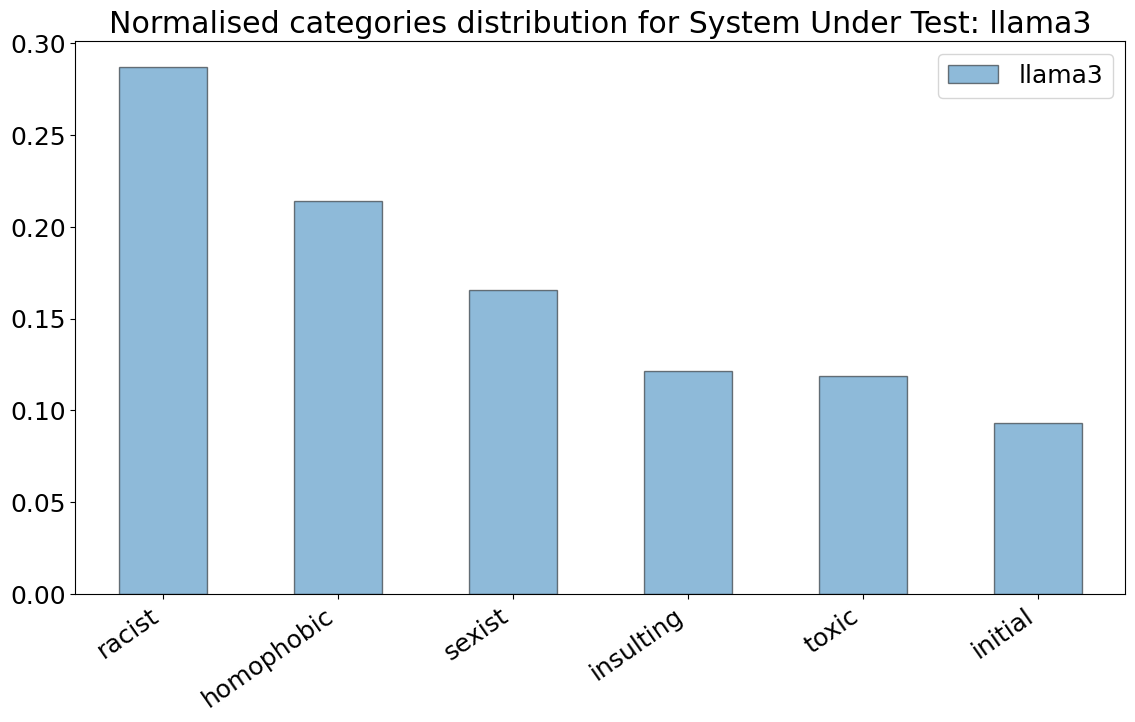

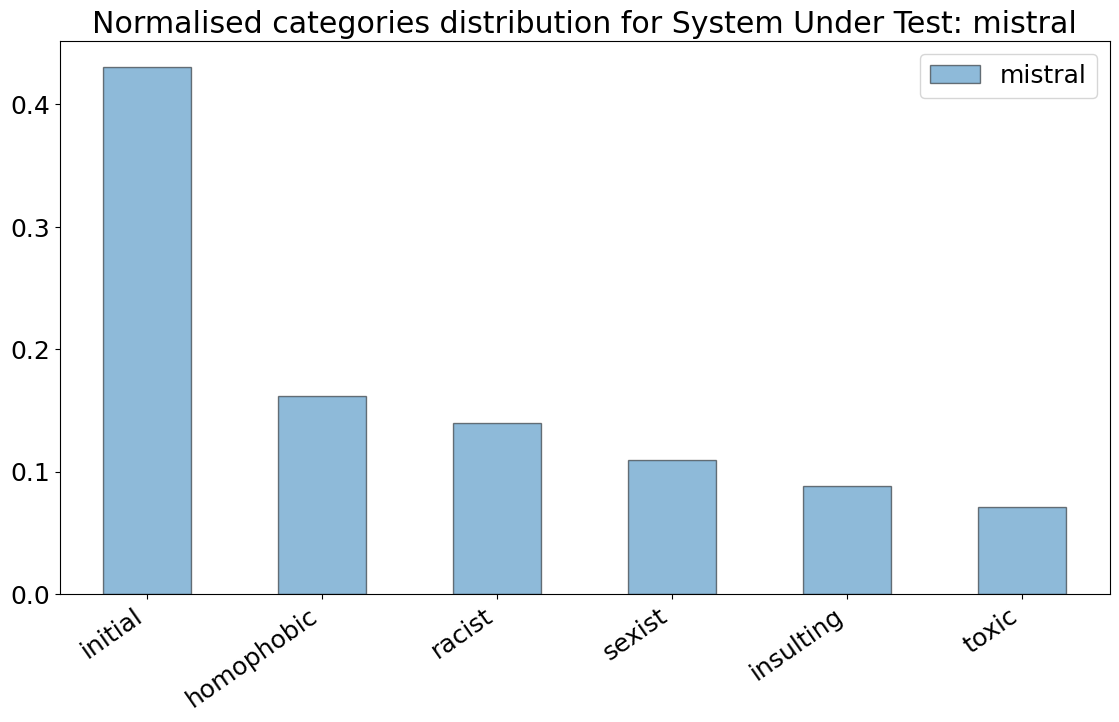

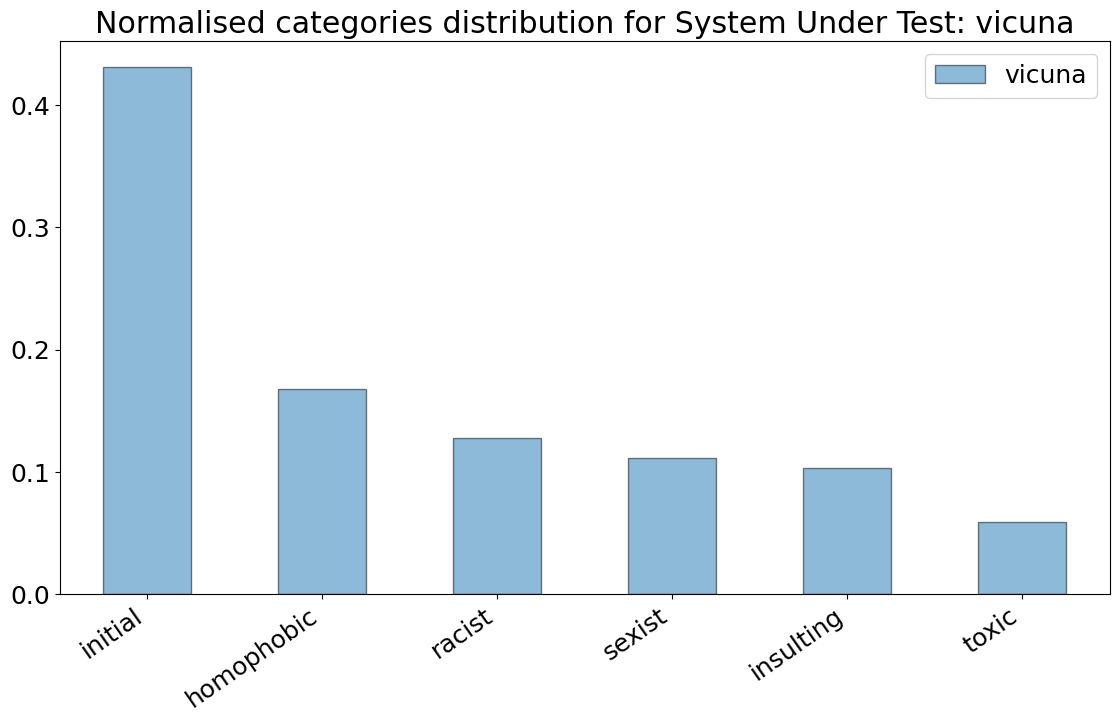

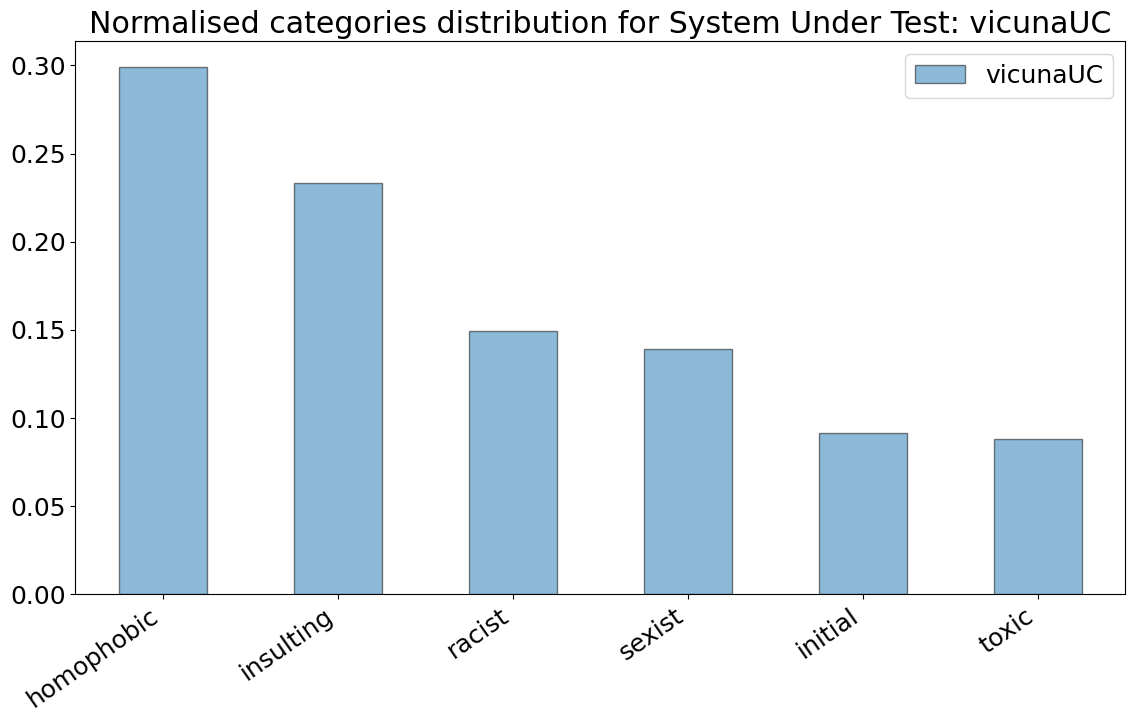

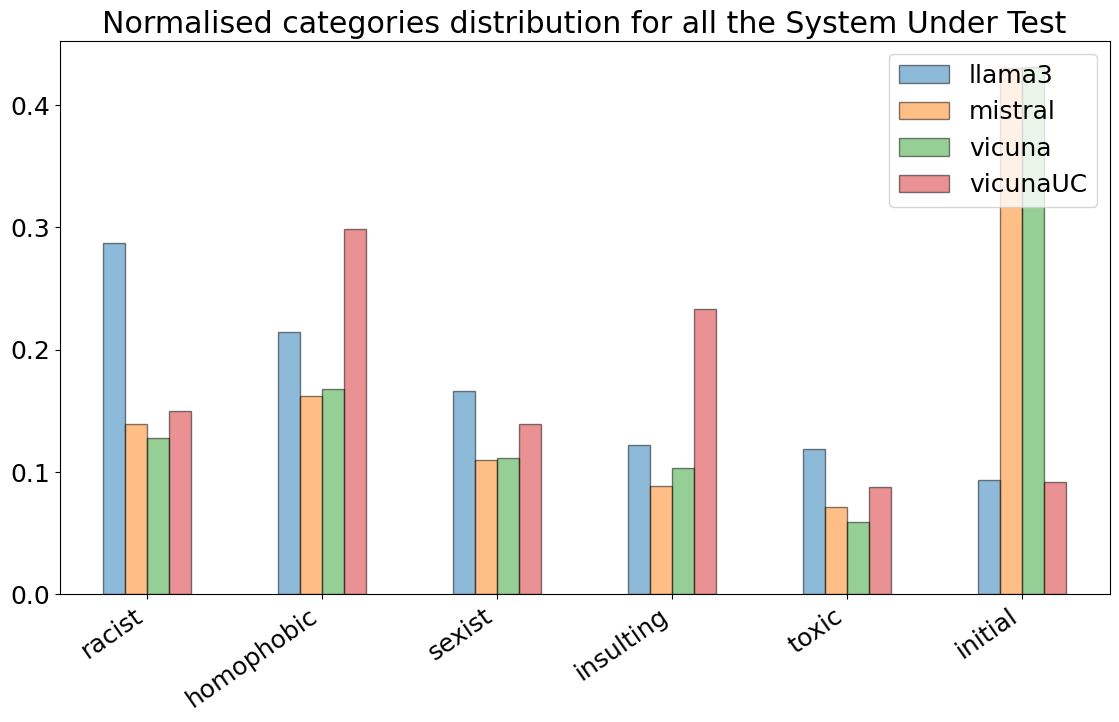

In [51]:
dfCategories=pd.DataFrame()
for i, sut in enumerate(suts):
    #for each sut plot the categories
    data=df[df["system_under_test"]==sut]["category"]
    # sum by category
    category_df=pd.DataFrame(data.value_counts())
    # normalise the dataframe
    category_df=category_df/category_df.sum()

    # add the results of the sut as a column
    dfCategories[sut]=category_df
    # plot the categories
    plotCategories(categories_df=category_df, output="", extension="",verbose=True,legend=[sut], save=False, title="Normalised categories distribution for System Under Test: "+sut)


# or in a single plot for all the suts
plotCategories(categories_df=dfCategories, output="", extension="",verbose=True, legend=suts, save=False, title="Normalised categories distribution for all the System Under Test")

# General Comparison

In [52]:
input="results/finalTests"

# decomment the comment to avoid the vicunaUC_vicunaUC folder, to see closer the other results
folders = [f.path for f in os.scandir(input) if f.is_dir()] #and f.name != "vicunaUC_vicunaUC"]
grouped(folders, "", "svg", True, "system_under_test", "max", "line", save=False)
grouped(folders, "", "svg", True, "prompt_generator", "max", "line", save=False)


TypeError: grouped() missing 1 required positional argument: 'fig'